In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


In [2]:
# Load and preprocess data
df = pd.read_csv('../Data_extraction/extracted_data.csv')
numerical_cols = ['Frequency of Traveling by Air', 'Vehicle Monthly Distance Km', 'CarbonEmission']
binary_cols = [col for col in df.columns if col not in numerical_cols]

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numerical_cols])

# Combine scaled numerical and binary features for clustering
X = np.hstack([X_scaled, df[binary_cols].values])


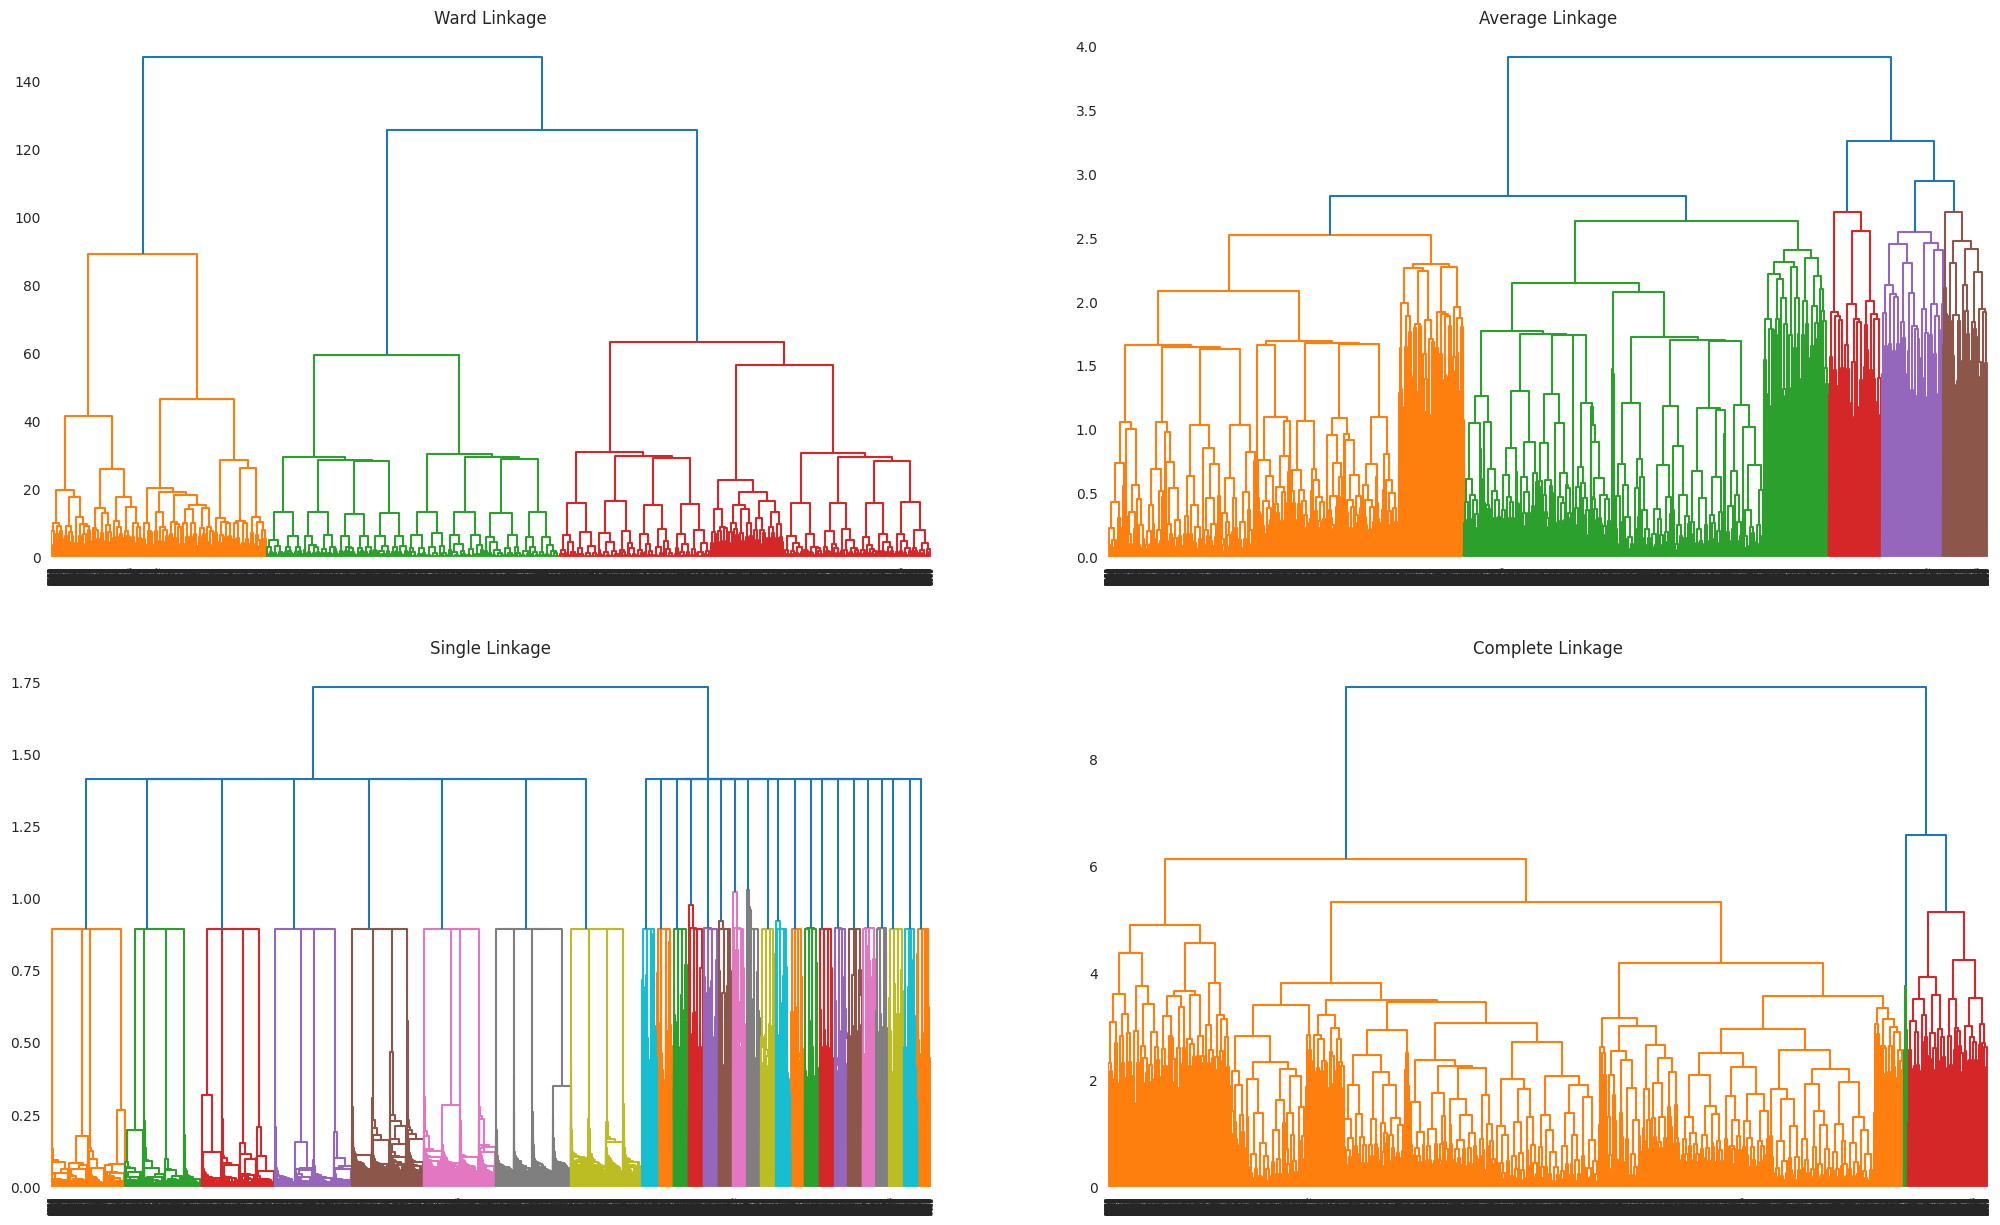

In [3]:
# Plot 4 kinds of hierarchical clustering dendrograms
plt.figure(figsize=(25, 15))

plt.subplot(221)
plt.title('Ward Linkage')
Z_ward = linkage(X, 'ward')
dendrogram(Z_ward, labels=df.index)
plt.savefig("ward.svg", dpi=600, format="svg")

plt.subplot(222)
plt.title('Average Linkage')
Z_average = linkage(X, 'average')
dendrogram(Z_average, labels=df.index)
plt.savefig("average.svg", dpi=600, format="svg")

plt.subplot(223)
plt.title('Single Linkage')
Z_single = linkage(X, 'single')
dendrogram(Z_single, labels=df.index)
plt.savefig("single.svg", dpi=600, format="svg")

plt.subplot(224)
plt.title('Complete Linkage')
Z_complete = linkage(X, 'complete')
dendrogram(Z_complete, labels=df.index)
plt.savefig("complete.svg", dpi=600, format="svg")
plt.show()


In [4]:
# Agglomerative Clustering with Ward linkage
agg = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')  # Reduced to 3 for simplicity
df['Cluster'] = agg.fit_predict(X)


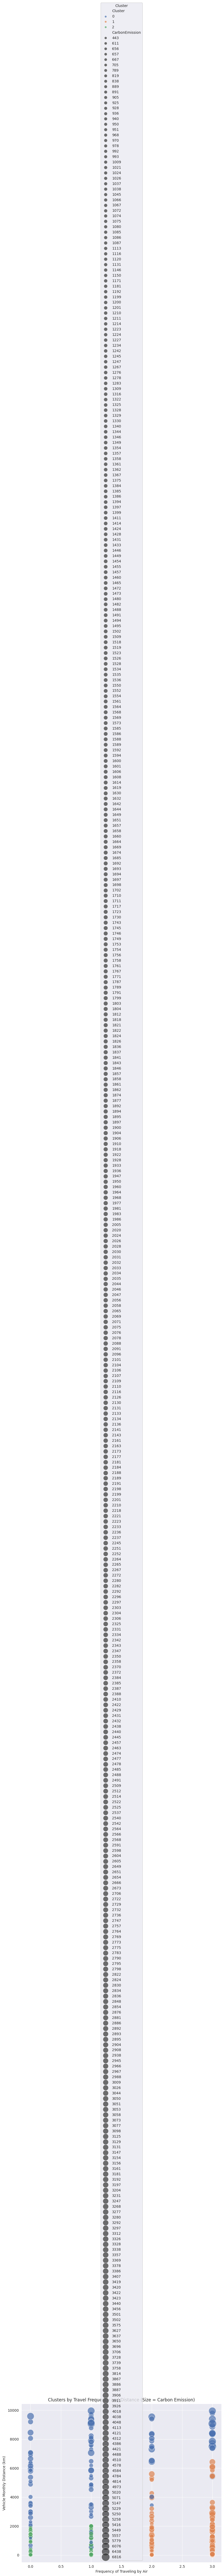

In [5]:
# 1. Random Sampling to Reduce Data Overlap (500 random samples)
sample_df = df.sample(n=500, random_state=42)

# 2. Plot the Clusters with Transparency (Alpha)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=sample_df['Frequency of Traveling by Air'],
    y=sample_df['Vehicle Monthly Distance Km'],
    hue=sample_df['Cluster'],
    size=sample_df['CarbonEmission'],
    palette='deep',
    sizes=(50, 500),
    legend='full',
    alpha=0.7  # Set transparency to avoid overlapping points
)
plt.title('Clusters by Travel Frequency and Distance (Size = Carbon Emission)')
plt.xlabel('Frequency of Traveling by Air')
plt.ylabel('Vehicle Monthly Distance (km)')
plt.legend(title='Cluster')
plt.show()


In [6]:
# 3. PCA Dimensionality Reduction for Better Visualization
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  # Use the features that were clustered

# Scatter plot with PCA reduction
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df['Cluster'],
    size=df['CarbonEmission'],
    palette='deep',
    sizes=(50, 500),
    legend='full',
    alpha=0.7  # Set transparency to avoid overlapping points
)
plt.title('PCA-based Clusters (Size = Carbon Emission)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


ValueError: Image size of 844x73673 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x800 with 1 Axes>

In [7]:
# Cluster assignments using distance criterion
F_single = fcluster(Z_single, 3.2, criterion='distance')
F_complete = fcluster(Z_complete, 6, criterion='distance')
df['Single_Cluster'] = F_single
df['Complete_Cluster'] = F_complete


In [8]:
# Mean of features per Complete linkage cluster
dfc = pd.DataFrame()
for i in range(1, max(F_complete) + 1):
    cluster_mean = df[df['Complete_Cluster'] == i].mean()
    dfc[i] = cluster_mean[numerical_cols + binary_cols]
dfc = dfc.sort_values(by='CarbonEmission', axis=1)
print("Mean Features per Complete Linkage Cluster:")
print(dfc)


Mean Features per Complete Linkage Cluster:
                                         2            1            4  \
Frequency of Traveling by Air     1.504120     1.040598     2.273128   
Vehicle Monthly Distance Km     664.467888  6300.717236  6618.994493   
CarbonEmission                 1945.779725  2614.707265  4262.801762   
coal                              0.244735     0.282051     0.272026   
electricity                       0.258600     0.248575     0.237885   
natural gas                       0.252714     0.230769     0.209251   
wood                              0.243950     0.238604     0.280837   
diesel                            0.022106     0.186610     0.210352   
electric                          0.027861     0.323362     0.004405   
hybrid                            0.023676     0.226496     0.157489   
lpg                               0.023806     0.183761     0.263216   
petrol                            0.023414     0.079772     0.364537   
private             

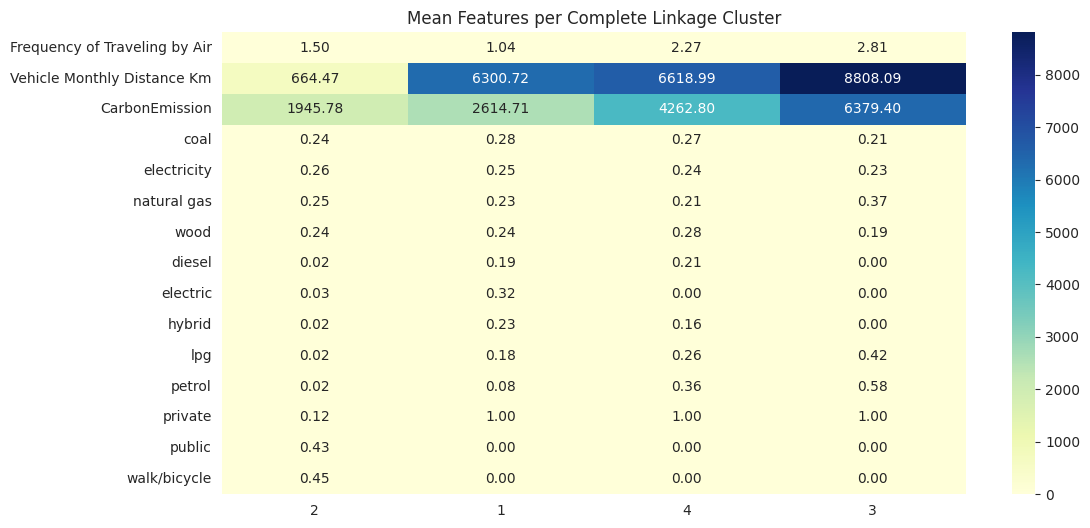

In [9]:
# Seaborn Heatmap of cluster means
plt.figure(figsize=(12, 6))
sns.heatmap(dfc, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Mean Features per Complete Linkage Cluster')
plt.show()
